# **Keras的循环神经网络（RNN）**

### **介绍**

循环神经网络（RNN）是一类神经网络，对于建模序列数据（例如时间序列或自然语言）非常有力。

在示意图上，RNN层使用`for`循环在序列的时间步上进行迭代，同时维护内部状态，该状态对已执行的时间步的信息进行编码。

Keras RNN API的设计重点是：

**易于使用**：内置的[`keras.layers.RNN`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN)，[`keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)，[`keras.layers.GRU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)层使你能够快速构建循环模型，而不必进行困难的配置选择。

**易于定制**：你还可以使用自定义行为定义自己的RNN单元层（`for`循环的内部），并将其与通用`keras.layers.RNN`层（`for`循环本身）一起使用。这使你能够以最少的代码灵活且快速地原型化不同的研究思路。

### 引入

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### **内置RNN层：一个简单的示例**

Keras中有三个内置的RNN层：

1. [`keras.layers.SimpleRNN`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN)，一个完全连接的RNN，它将上一个时间步的输出将馈送到下一个时间步。

2. [`keras.layers.GRU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)，在[Cho et al.,2014](https://arxiv.org/abs/1406.1078)中首先被提出 。

3. [`keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)，在[Hochreiter & Schmidhuber, 1997.](https://www.bioinf.jku.at/publications/older/2604.pdf)中首先被提出 。

2015年初，Keras拥有LSTM和GRU的第一个可重用的开源Python实现。

下面是一个简单的`Sequential`模型示例，该模型处理整数序列，将每个整数嵌入到64维向量中，然后使用`LSTM`层处理向量序列。

In [2]:
model = keras.Sequential()
# 添加一个输入单词量大小为1000，输出嵌入尺寸为64的嵌入层
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# 添加一个128个内部单元的LSTM层
model.add(layers.LSTM(128))

# 添加一个10个内部单元的密度层
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


内置RNN支持许多有用的功能：

+ 通过`dropout`和`recurrent_dropout`参数进行循环dropout
+ 可以通过`go_backwards`参数反向处理输入序列
+ 通过`unroll`参数进行循环展开（在CPU上处理短序列时可能更快）
+ ...和更多。

有关更多信息，请参见[RNN API文档](https://keras.io/api/layers/recurrent_layers/)。

### **输出和状态**

默认情况下，RNN层的输出包含每个样本对应的一个向量。该向量是最后一个时间步相对应的RNN单元输出，其中包含有关整个输入序列的信息。此输出的形状为`(batch_size, units)`，其中`units`对应于传递给层构造函数的`units`参数。

如果你设置`return_sequences=True`，则RNN层还可以返回每个样本的整个输出序列（每个样本的每个时间步的一个向量），此输出的形状是`(batch_size, timesteps, units)` 。

In [3]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# GRU的输出将是形状为（batch_size，timesteps，256）的3D张量
model.add(layers.GRU(256, return_sequences=True))

# SimpleRNN的输出将是形状为（batch_size，128）的2D张量
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


此外，RNN层可以返回其最终的内部状态，返回的状态可用于稍后恢复RNN执行或[初始化另一个RNN](https://arxiv.org/abs/1409.3215)，此设置通常用于编码器-解码器的Seq2Seq模型，其中编码器的最终状态用作解码器的初始状态。

要将RNN层配置为返回其内部状态，需要在创建层时将`return_state`参数设置为`True`。值得注意的是，`LSTM`具有2个状态张量，但`GRU`仅具有1个。

要配置层的初始状态，只需使用关键字参数`initial_state`来调用层即可。请注意，状态的形状需要与层的单元大小匹配，如以下示例所示。

In [4]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# 返回除输出外的状态
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# 将这两种状态作为初始状态传递到新的LSTM层
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()
 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     64000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     128000      input_2[0][0]                    
_______________________________________________________________________________________

### **RNN层和RNN单元**

除了内置的RNN层之外，RNN API还提供了单元级API。与处理整批量输入序列的RNN层不同，RNN单元仅处理单个时间步。

该单元在RNN层的`for`循环的内部。在[`keras.layers.RNN`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN)层中包装一个单元，可以为你提供能够处理批量序列的层，例如RNN(LSTMCell(10)) 。

从数学角度来看，`RNN(LSTMCell(10))`产生与`LSTM(10)`相同的结果。实际上，在TF v1.x中该层的实现只是创建相应的RNN单元并将其包装在RNN层中。但是，使用内置的`GRU`和`LSTM`层可以使用CuDNN，您可能会看到更好的性能。

内置三个RNN单元，每个单元对应于匹配的RNN层。

+ [`keras.layers.SimpleRNNCell`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNNCell)对应于SimpleRNN层。

+ [`keras.layers.GRUCell`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRUCell)对应于GRU层。

+ [`keras.layers.LSTMCell`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell)对应于LSTM层。

单元抽象以及通用的`keras.layers.RNN`类使得实现自定义RNN体系结构变得非常容易。

### **跨批状态**

当处理非常长的序列（可能是无限的）时，你可能需要使用跨批状态的模式。

通常，每次看到新批次时，都会重置RNN层的内部状态（即，假定该层看到的每个样本都独立于过去的），该层仅在处理给定样本时保持状态。

如果你有很长的序列，则将它们分成较短的序列，然后将这些较短的序列依次传入RNN层而不重置该层的状态将非常有用。这样，即使一次只看到一个子序列，该层也可以保留有关整个序列的信息。

你可以通过在构造函数中设置`stateful=True`来实现。

如果有一个序列`s = [t0, t1, ... t1546, t1547]` ，则将其拆分为

In [ ]:
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]

然后，你可以通过以下方式进行处理：

In [ ]:
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
  output = lstm_layer(s)

当你想要清除状态时，可以使用`layer.reset_states()`。

注：在此设置中，给定批次中的样本i将被假定为前面批次样本的延续。这意味着所有批次应包含相同数量的样本（批次大小）。例如，如果一个批次包含`[sequence_A_from_t0_to_t100, sequence_B_from_t0_to_t100]`，则下一个批次应包含`[sequence_A_from_t101_to_t200, sequence_B_from_t101_to_t200]` 。

下面是一个完整的示例：

In [ ]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states())会将缓存的状态重置为原始的initial_state。
# 如果未提供initial_state，则默认情况下将使用零状态。
lstm_layer.reset_states()

### **RNN状态重用**

RNN层的状态记录不包含在`layer.weights()`中。如果你想重用RNN层的状态，则可以通过**layer.states**检索状态值并将其用作新层的初始状态，就像函数式API（或子类化模型）中的`new_layer(inputs, initial_state=layer.states)`。

请注意，在这种情况下可能不会使用`Sequential`模型，因为它仅支持具有单个输入和输出的层，初始状态的额外输入使得无法使用`Sequential`模型。

In [ ]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)

### **双向RNN**

RNN模型不仅可以从头到尾处理序列，而且可以反向处理序列。通常情况下，对于时间序列以外的序列（例如文本），双向RNN效果会更好。例如，要预测句子中的下一个单词，通常使单词具有上下文。

Keras提供了一个简单的API，用于构建此类双向RNN：[`keras.layers.Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)包装器。

In [5]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


`Bidirectional`将复制传入的RNN层，并翻转新层的`go_backwards`字段，以便它能够处理输入的反序列。

默认情况下，`Bidirectional` RNN的输出将是前向层输出和后向层输出的总和。如果你需要其他合并操作（如concatenation），请在`Bidirectional`的构造函数中更改`merge_mode`属性。有关`Bidirectional`更多详细信息，请检查[API文档](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional/)。

### **性能优化和CuDNN内核**

在TensorFlow 2.0中，内置的LSTM和GRU层已更新为在GPU可用时，默认使用CuDNN内核。通过此更改，先前的`keras.layers.CuDNNLSTM/CuDNNGRU`层已被弃用，你可以构建模型而不必关心模型所运行的硬件。

由于CuDNN内核是根据某些假设构建的，因此，这意味着**如果你更改内置LSTM或GRU层的默认设置，则该层将无法使用CuDNN内核**。例如：

+ 将`activation`方法从`tanh`更改为其他激活方法。
+ 将`recurrent_activation`方法从`sigmoid`更改为其他方法。
+ 设置`recurrent_dropout` > 0。
+ 将`unroll`设置为True，这将强制LSTM/GRU把内部的`tf.while_loop`分解为`for`循环。
+ 将`use_bias`设置为False。
+ 当输入数据未严格进行右填充时，使用掩码（如果掩码对应于严格的右填充数据，则仍可以使用CuDNN，这是最常见的情况）。

有关约束的详细列表，请参阅[LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM/)和[GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU/)层的文档。

#### **在CuDNN内核可用时使用它**
让我们编写一个简单的LSTM模型来演示性能差异。

我们将使用MNIST数字的行序列作为输入序列（将每个像素行作为时间步进行处理），并预测该数字的标签。

In [6]:
batch_size = 64
# 每个MNIST图像批量都是一个形状为（batch_size，28，28）的张量
# 每个输入序列的大小为（28，28）（将高度视为时间）
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# 创建RNN模型
def build_model(allow_cudnn_kernel=True):
    # CuDNN仅在层级别时可用，而在单元级别时不可用。
    # 这意味着`LSTM(units)`将使用CuDNN内
    # 核，而RNN(LSTMCell(units))将在非CuDNN内核上运行。
    if allow_cudnn_kernel:
        # 具有默认选项的LSTM层使用CuDNN
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # 在RNN层中包装LSTMCell不会使用CuDNN
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model


让我们加载MNIST数据集：

In [7]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

11493376/11490434 [==============================] - 0s 0us/step


让我们创建一个模型实例并对其进行训练。

我们选择`sparse_categorical_crossentropy`作为模型的损失函数。模型的输出的形状为`[batch_size, 10]`。该模型的目标是一个整数向量，每个整数都在0到9的范围内。

In [8]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 5s 5ms/step - loss: 0.9482 - accuracy: 0.7034 - val_loss: 0.4980 - val_accuracy: 0.8415


现在，让我们与不使用CuDNN内核的模型进行比较：

In [9]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 43s 45ms/step - loss: 0.3838 - accuracy: 0.8857 - val_loss: 0.4986 - val_accuracy: 0.8259


在安装了NVIDIA GPU和CuDNN的计算机上运行时，与使用常规TensorFlow内核的模型相比，使用CuDNN构建的模型的训练速度要快得多。

启用了CuDNN的模型也可以用于仅有CPU的环境中进行预测，下面的[`tf.device`](https://www.tensorflow.org/api_docs/python/tf/device)只是强制闲置设备。如果没有可用的GPU，默认情况下该模型将在CPU上运行。

你完全不必关心正在运行的硬件，这不是很酷的一件事儿吗？

Predicted result is: [3], target result is: 5


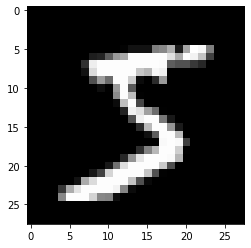

In [10]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

### **具有列表/字典输入或嵌套输入的RNN**

嵌套结构使得实现者在单个时间步之内能够包括更多信息，例如，一个视频帧可以同时具有音频和视频输入。在这种情况下，数据形状可能是：

`[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]`

在另一个示例中，笔迹数据可以具有笔的当前位置的坐标x和y以及压力信息。因此，数据表示可以是：

`[batch, timestep, {"location": [x, y], "pressure": [force]}]`

以下代码提供了一个示例，展示如何构建接受此类结构化输入的自定义RNN单元。

### **定义一个支持嵌套输入/输出的自定义单元**

有关编写自己的层的详细信息，请参见[通过子类化创建新的层和模型](https://www.tensorflow.org/guide/keras/custom_layers_and_models/)。

In [11]:
class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super(NestedCell, self).__init__(**kwargs)

    def build(self, input_shapes):
        # input_shape应该包含2个条目，[（batch，i1），（batch，i2，i3）]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # 输入的形状应为[(batch, input_1), (batch, input_2, input_3)]
        # 状态的形状应为[(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states

    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}

#### **使用嵌套的输入/输出构建RNN模型**

让我们使用[`keras.layers.RNN`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN)层和我们的自定义单元构建一个Keras模型。

In [12]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
 

#### **使用随机生成的数据训练模型**

由于此模型没有好的候选数据集，因此我们使用随机的Numpy数据进行演示。

In [13]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

10/10 [==============================] - 0s 33ms/step - loss: 0.7470 - rnn_1_loss: 0.2562 - rnn_1_1_loss: 0.4908 - rnn_1_accuracy: 0.0953 - rnn_1_1_accuracy: 0.0366


使用[`keras.layers.RNN`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN)层，只需要为序列中的单个步骤定义数学逻辑，而[`keras.layers.RNN`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN)层将为你处理序列迭代，这是一种快速原型化新型RNN（例如LSTM变体）的强大方法。

有关更多详细信息，请访问[API文档](https://https//www.tensorflow.org/api_docs/python/tf/keras/layers/RNN/)。